# DESI PV Y1 TFR Calibration - Tempel Merging Groups and Clusters Catalog

Using the list of galaxies and groups defined by Tempel et al. in [*Merging groups and clusters of galaxies from the SDSS data: 
the catalogue of groups and potentially merging systems*](https://www.aanda.org/articles/aa/pdf/2017/06/aa30499-17.pdf), identify DESI observations with measurements suitable for calibrating the Tully-Fisher relation. 

Version: **5 Apr 2025** 

**Note:** This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 groups, so we need to change the default color map so that they are all plotted with different colors
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('Dark2').colors)

import ligo.skymap.plot

from astropy.table import Table, QTable, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/m/mjkeller/DESI_SGA/TF')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')
h = 1.
H0 = 100*h
q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [3]:
sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
# sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06,122.32238811543634,2.5088414493427758,N
55,SGA-2020 55,PGC120394

# Load Morphological Classification using the SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [4]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
# ai_morphpath = '.'
ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [5]:
sum(ai_morphtab['Spiral_Pred'] == 'Spiral') + sum(ai_morphtab['Elliptical_Pred'] == 'Elliptical') + sum(ai_morphtab['Lenticular_Pred'] == 'Lenticular') + sum(ai_morphtab['Irregular_Pred'] == 'Irregular')

9710

Cool, so Julia gave us a table with only those objects with certain classifications from all three binary classifiers.  Therefore, if `Spiral_Pred` = 'Spiral', then this is a spiral galaxy.

In [6]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

# Combine ML morphtypes with SGA catalog

In [7]:
'''
#- Match SGA_ID in the two tables and return index into ai_morphtab
idx = np.where(ai_morphtab['SGA_ID'][:, None] == sgatab['SGA_ID'][None, :])[1]

#- Create a new column in the SGA table
sgatab['MORPHTYPE_AI'] = ai_morphtab['Predicted_Type'][idx]
''';

sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $10~\mathrm{km/s} < V_\mathrm{rot} < 1000~\mathrm{km/s}$ at $0.4R_{26}$
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection
* $i > 45^\circ$
* Spiral-type morphology

The first three items have already been applied.

In [8]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max
'''
#- Morphology cut: spiral, not S0
is_good_morph = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    try:
        if (sgatab['MORPHTYPE'][i][0] == 'S' and sgatab['MORPHTYPE'][i][:2] != 'S0') or (sgatab['MORPHTYPE_AI'][i][0] == 'S'):
            is_good_morph[i] = True
    except IndexError as e:
        continue
'''
#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- Combine selections:
# is_good_sga = is_good_incl & is_good_morph
is_good_sga = is_good_incl & is_good_morph_ML

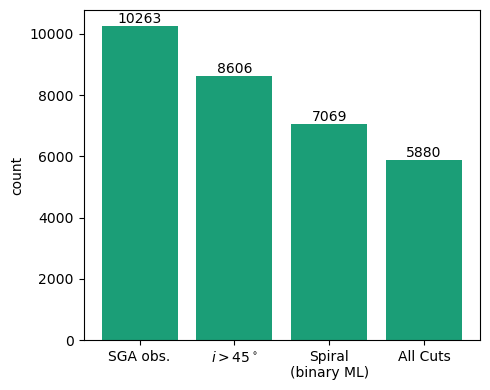

In [9]:
data = {
    'SGA obs.' : len(sgatab),
    # r'$10 < V_\mathrm{rot} < 1000$' : np.sum(is_good_velo),
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(5,4), tight_layout=True)
bars = ax.bar(names, values)
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [10]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### Dust corrections

In [11]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [12]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/global/homes/m/mjkeller/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [13]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [14]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [15]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [16]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [17]:
temp_infile = open('iron_internalDust_z0p1_mcmc.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [18]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)

internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [19]:
internalDust_corr, internalDust_corr_err = internal_dust(sgatab['BA'], 
                                                         internalDust_coeffs, 
                                                         internalDust_coeffs_err)

## Apply corrections

In [20]:
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr

In [21]:
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err**2)

## Load SN Ia Calibrators for the TFR Zero Point

List of SNe Ia from UNION3 and Pantheon+ from Anthony Carr. Match these to the SGA iron observations that have passed all quality cuts.

In [22]:
# zeroptpath = '../cache/'
# zeroptpath = '.'
zeroptpath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/tf_0pt/'
zeroptab = Table.read(os.path.join(zeroptpath, 'SGA_SNmatches+secondary.fits'))

In [23]:
#- Extract the 0-point SNe Ia that match SGA IDs in the good catalog (passed all rotation curve cuts).
#  Merge the tables so we can use the zero point later.
idx = np.in1d(zeroptab['SGA_ID'], sgatab['SGA_ID'][is_good_sga])
# zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx]

zeroptab = join(sgatab, zeroptab[['SGA_ID', 'MU_PRIMARY', 'MU_SECONDARY', 'MU_ERR', 'MU_SOURCE']][idx], keys='SGA_ID')

#- Write catalog to file
zeroptab.write('SGA_distances_0pt_iron_z0p1.fits', overwrite=True)
zeroptab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,MORPHTYPE_AI,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,MU_PRIMARY,MU_SECONDARY,MU_ERR,MU_SOURCE
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,str10,float64,float64,float64,float64,float64,bytes22
40926.0,SGA-2020 40926,PGC1068066,1068066,152.623449,-3.6906752,--,92.0,0.36307806,0.61659503,0.21329089,23.94848,17.52,False,LEDA-20181114,11069,PGC1068066,1,True,152.623449,-3.6906752,0.36307806,1525m037,152.62370459277508,-3.690698038306378,0.52914876,SB26,93.82398,0.6641905,152.623658987301,-3.690602374956275,13.956456,6.5563784,6.258357,5.964005,3.1641104,4.769187,6.5240216,8.290042,9.929943,11.569215,13.095884,14.571321,15.874463,18.975252,18.228054,17.692598,18.371702,17.647062,17.125422,17.974627,17.274006,16.773363,17.7288,17.050247,16.55726,17.57161,16.909569,16.427755,17.470478,16.816118,16.34705,17.408316,16.75774,16.293118,17.365652,16.719202,16.2552,17.339867,16.696472,16.233257,0.015255946,0.023526663,0.031296223,0.045312252,0.04817149,0.052810065,0.073413566,0.11950123,0.11073505,0.013739682,0.014882605,0.01610527,0.009548919,0.010457335,0.011346222,0.007930538,0.008566626,0.009396279,0.007392727,0.007950613,0.008675855,0.0071034827,0.0075082057,0.008207054,0.006730093,0.0070925383,0.007871118,0.0064921877,0.006838123,0.007653001,0.0063312803,0.006676669,0.0075182593,0.0062460634,0.0065811076,0.007477449,17.216694,0.5720894,0.84683824,2.769856,1.172794,16.567944,0.6329212,0.70157576,2.518496,1.1045564,16.112835,0.6603067,0.60

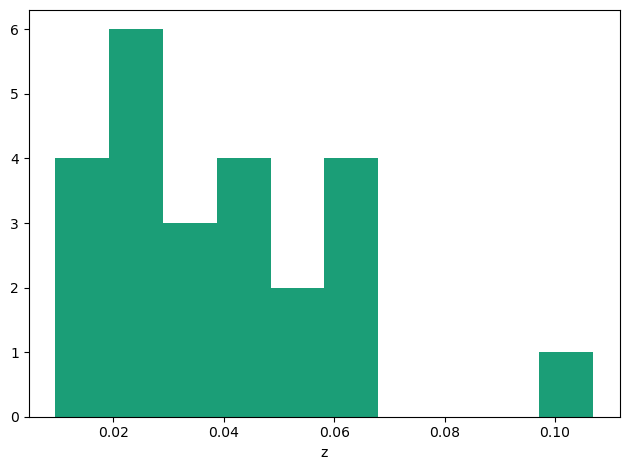

In [24]:
plt.figure(tight_layout=True)

plt.hist(zeroptab['Z_DESI'])

plt.xlabel('z');

In [25]:
# Only keep galaxies with a primary SN match
# zeroptab = zeroptab[~zeroptab['MU_PRIMARY'].mask]

In [26]:
np.unique(zeroptab['MU_SOURCE'], return_counts=True)

(<Column name='MU_SOURCE' dtype='bytes22' length=16>
      1999ac
      2001da
      2001ep
       2002G
      2005hc
      2006bw
      2007ba
      2010ai
      500038
 ASASSN-16ct
   AT2017cfc
     PS15cms
     PS16axi
     PS16ayd
     PS16bnz
   SN2017cjv,
 array([1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 4, 1, 2, 2, 2, 1]))

### Plot the Zero Point Calibrators

Sky coordinates of the SNe with good DESI rotational velocities.

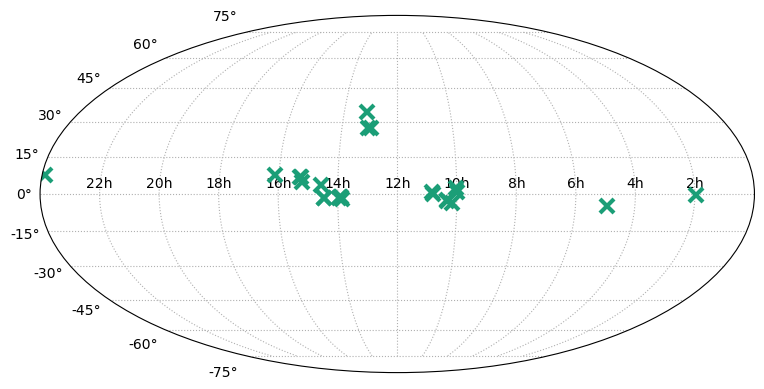

In [27]:
sne_coords = SkyCoord(ra=zeroptab['RA'], dec=zeroptab['DEC'], frame='icrs', unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
_ra = np.radians(180*u.deg - sne_coords.ra)
_dec = np.radians(sne_coords.dec)
ax.plot(_ra, _dec, 'x', ms=10, mew=3)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_SNIa_calibrators.png', dpi=150);

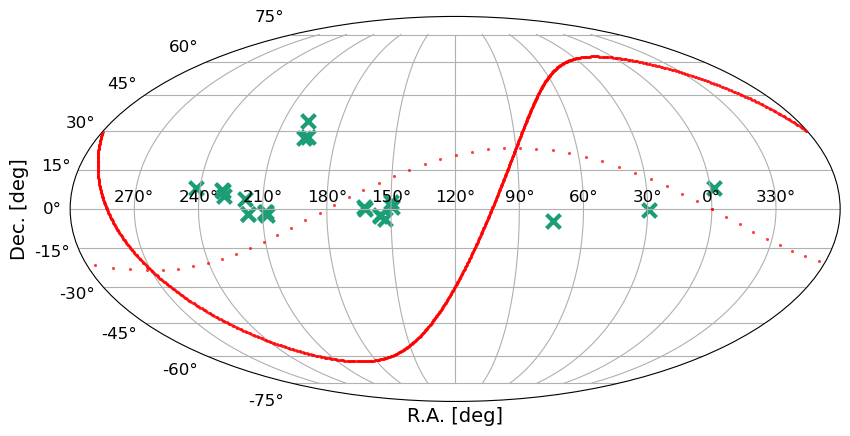

In [28]:
ax = init_sky()

ax.scatter(ax.projection_ra(sne_coords.ra.value), 
           ax.projection_dec(sne_coords.dec.value), 
           marker='x', 
           s=100,
           linewidth=3)

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.tick_params(axis='both', which='major', labelsize=12)

# plt.savefig('../../Figures/Y1/iron_0pt_sky.png', dpi=150, facecolor='none');

### Compute the Absolute Magnitude of the 0-pt Calibrators based on the Distance

Compute the absolute magnitude
$$
M_r - 5\log{h} = m_r - \mu - 5\log{h},
$$
where $h$ is the reduced Hubble constant used to calibrate the distance modulus $\mu$.

Since our calibrators are from Pantheon+SH0ES, where distances are based on the distance ladder, there is no assumed value of $h$.

In [29]:
#- Clean up the distance modulus
use_primary = zeroptab['MU_SECONDARY'] < 0
mu = zeroptab['MU_SECONDARY']
mu[use_primary] = zeroptab['MU_PRIMARY'][use_primary]
# mu = zeroptab['MU_PRIMARY']

#- Compute the absolute magnitude
zeroptab['R_ABSMAG_SB26'] = zeroptab['R_MAG_SB26_CORR'] - mu
zeroptab['R_ABSMAG_SB26_err'] = np.sqrt(zeroptab['R_MAG_SB26_ERR_CORR']**2 + zeroptab['MU_ERR']**2)

In [30]:
# Save this table
zeroptab.write('SGA-2020_iron_Vrot_VI_0pt_calib_z0p1.fits', overwrite=True)

# Access Cluster Catalog

These groups come from the group catalog used by Tempel et al. in [*Merging groups and clusters of galaxies from the SDSS data: 
the catalogue of groups and potentially merging systems*](https://www.aanda.org/articles/aa/pdf/2017/06/aa30499-17.pdf), ApJ 896:3, 2020.

Cluster membership is defined using a modified friends-of-friends 

where $R_p$ is the projected distance from the center of the cluster, $R_{2t}$ is the projected cluster second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [31]:
groups = Table.read('/global/homes/m/mjkeller/table1.dat', format = "ascii.no_header", names = ("GalID", "specID", "objID", "GroupID", "Ngal", "Rank", "Dist.g", "zob", "zcmb", "e_zobs", "Dist", "Distcor", "RAdeg", "DEdeg", "GLON", "GLAT", "SGLON", "SGLAT", "lambda", "eta", "Xpos", "Ypos", "Zpos", "umag", "gmag", "rmag", "imag", "zmag", "uMAG", "gMAG", "rMAG", "iMAG", "zMAG", "k+e.u", "k+e.g", "k+e.r", "k+e.i", "k+e.z", "ext.u", "ext.g", "ext.r", "ext.i", "ext.z", "Lr", "w", "pE", "pS0", "pSa", "pSc", "Dist.e", "Den1", "Den2", "Den4", "Den8"))
print(len(groups), 'galaxies')
groups[:10]

584449 galaxies


GalID,specID,objID,GroupID,Ngal,Rank,Dist.g,zob,zcmb,e_zobs,Dist,Distcor,RAdeg,DEdeg,GLON,GLAT,SGLON,SGLAT,lambda,eta,Xpos,Ypos,Zpos,umag,gmag,rmag,imag,zmag,uMAG,gMAG,rMAG,iMAG,zMAG,k+e.u,k+e.g,k+e.r,k+e.i,k+e.z,ext.u,ext.g,ext.r,ext.i,ext.z,Lr,w,pE,pS0,pSa,pSc,Dist.e,Den1,Den2,Den4,Den8
int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,2552560286640924672,1237667108498440262,1,7,1,438.288185,0.10088736,0.101669636,1.8697e-05,438.804776,438.336385,122.060976235,16.369132777,206.201398985,24.164140163,56.644886856,-53.185360149,-58.696419344,0.348279091,374.526163,227.743328,1.384381,15.999198,15.184734,13.954014,14.183157,13.937554,-22.131911,-23.196076,-24.405571,-24.106044,-24.394216,-0.287705,-0.038004,-0.05923,-0.129613,-0.087044,0.147809,0.108757,0.078879,0.059812,0.042407,41.5172,1.697823,0.19025,0.43386,0.18794,0.18794,35.566085,597.16501638,91.39437291,21.91662205,8.91054125
297963,2552559736885110784,1237667108498440277,1,7,2,438.288185,0.101033255,0.101815006,2.1928e-05,439.416563,438.393468,122.020980121,16.360700637,206.19354466,24.125508179,56.596662602,-53.211992115,-58.734091325,0.369776339,374.724619,227.526124,1.468432,20.086974,18.167317,17.095039,16.649851,16.416131,-18.28905,-20.376015,-21.343928,-21.697949,-21.983936,-0.042789,0.124518,0.020153,-0.071014,-0.018746,0.144855,0.106583,0.077303,0.058616,0.04156,2.47498,1.697823,0.03965,0.61383,0.27964,0.06688,35.32141,576.03591785,91.74913354,22.18330172,8.95608821
314723,2552519879588603904,1237667142858899877,1,7,3,438.288185,0.10151869,0.102299513,1.7477e-05,441.455278,438.583691,121.985849724,16.422769183,206.116528794,24.11860931,56.495919555,-53.175311474,-58.733505737,0.505853207,374.884889,227.62455,2.009705,20.05769,18.096794,17.178307,16.755748,16.472958,-18.313511,-20.411608,-21.260102,-21.563896,-21.92021,-0.047612,0.089588,0.019595,-0.09917,-0.025646,0.14492,0.10663,0.077337,0.058642,0.041578,2.29108,1.697823,0.01026,0.05232,0.76391,0.17351,35.446809,473.40300902,85.29778122,21.4804246,8.8786183
381383,2552522628367673344,1237667142858899914,1,7,4,438.288185,0.10037472,0.101154935,2.5184e-05,436.638297,438.134241,121.975487764,16.49058534,206.043831309,24.135811281,56.424821448,-53.121649908,-58.709214307,0.629295763,374.404272,227.545178,2.499294,20.362229,18.494674,17.473126,16.984563,16.668633,-18.021644,-20.044971,-20.980751,-21.368719,-21.74594,-0.034941,0.120831,0.035063,-0.065533,-0.004241,0.156539,0.11518,0.083538,0.063344,0.044912,1.77133,1.697823,0.00692,0.02671,0.82561,0.14075,35.211785,326.81310144,76.8150851,21.43253206,8.89909769
408210,2552560561518831616,1237667142858899835,1,7,5,438.288185,0.09898493,0.099765387,2.2063e-05,430.786589,437.588245,121.947446172,16.394022935,206.129839415,24.073488887,56.466842501,-53.218671247,-58.77966768,0.491874461,374.21688,226.806983,1.947147,20.218531,18.470166,17.590959,17.18533,16.999678,-18.133518,-20.014456,-20.835365,-21.115845,-21.380781,-0.066765,0.065808,0.00751,-0.117638,-0.038355,0.147497,0.108527,0.078713,0.059686,0.042318,1.54934,1.697823,0.17803,0.56686,0.10969,0.14542,34.249144,316.76507418,83.71981379,23.69615532,9.20662148
409419,2552558362495576064,1237667108498440523,1,7,6,438.288185,0.101507574,0.102289125,2.1932e-05,441.411572,438.579613,122.004052761,16.353877572,206.193503329,24.107891077,56.578968758,-53.226067768,-58.751607703,0.37340246,374.953302,227.508022,1.482714,20.324769,18.480507,17.655746,17.305957,17.226434,-18.029211,-19.98554,-20.763287,-20.962716,-21.134855,-0.064834,0.047233,0.000219,-0.150141,-0.057524,0.144576,0.106377,0.077154,0.058503,0.04148,1.44982,1.697823,0.14079,0.65654,0.14832,0.05

In [32]:
grp_ids = np.unique(groups['GroupID'], return_counts = True)
grp_sufficient = []

# check for the number of groups with "enough" galaxies (more than 15) 
grp_plurality = np.extract(grp_ids[1]>15, grp_ids)
for i in range(len(grp_ids[0])): 
    if i in grp_plurality: 
        grp_sufficient.append(i)
print(len(grp_sufficient),'groups')

954 groups


# Find Cluster Membership

Identify SGA galaxies in the list of galaxy groups from Ian Williams (2025, WIP).

Loop through the data and keep only groups where DESI has at least 20 galaxies with TF measurements passing all quality cuts.

In [33]:
#- Sky coordinates of SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

sga_coords = SkyCoord(sgatab_sel['RA']*u.deg, sgatab_sel['DEC']*u.deg)
z_sga_desi = sgatab_sel['Z_DESI']
print(len(sgatab_sel), "galaxies")

5880 galaxies


In [34]:
# match between the Tempel catalog and the SGA galaxies
sga_groups = {}
m_dwarf_groups = {}
n_cluster_min = 15

# Sky coordinates of Ian's galaxies
grp_coords = SkyCoord(groups['RAdeg']*u.degree, groups['DEdeg']*u.degree)

match_ids, match_dist, match_sep = sga_coords.match_to_catalog_sky(grp_coords)
print(len(match_sep), "galaxies")

5880 galaxies


# Separation Quality Checking

Using the same processes as in `/DESI_SGA/TF/Y1/TF_Y1_VI.ipynb` to conduct visual inspection, determine which bins from the above histogram should be considered "good" coordinate matches. Relevant notebook: `/mjkeller/DESI_SGA/TF/Y1/TF_Y1_cluster_VI_MJ_DESI.ipynb`. Ultimate outcome: keep just the first bin, which contains 4647 of the 4904 galaxies with a calculated separation less than 1/300º, or 94.8% of the constrained galaxies. 

The processing that leads to the `indices` variable below is available in the stated notebook. Indices valid for the lists `match_ids`, `match_dist`, and `match_sep`. 

In [35]:
sep_R26 = (2*match_sep)/sgatab_sel['D26']
sgatab_sel['GroupID'] = groups['GroupID'][match_ids]
sgatab_sel[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,MORPHTYPE_AI,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,GroupID
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,str10,float64,float64,int64
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247

In [36]:
# make the separation cut as defined

VI_tab = sgatab_sel[sep_R26 <= .1]
print(len(VI_tab), 'total matching galaxies passing VI')
VI_tab[:5]

4487 total matching galaxies passing VI


SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,MORPHTYPE_AI,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,GroupID
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,str10,float64,float64,int64
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247

In [37]:
# check the number of groups with different numbers of galaxies AFTER the VI cut

grp_GroupID, grp_count = np.unique(VI_tab['GroupID'], return_counts = True)
print('5+ galaxies:', np.sum(grp_count >= 5))
print('8+ galaxies:', np.sum(grp_count >= 8))
print('10+ galaxies:', np.sum(grp_count >= 10))
print('15+ galaxies:', np.sum(grp_count >= 15))

5+ galaxies: 7
8+ galaxies: 2
10+ galaxies: 1
15+ galaxies: 1


In [38]:
# keep groups with more than 8 galaxies

full_group = grp_count >= 8
grp_ids = []
for i in range(len(full_group)): 
    if full_group[i] == True and i > 0: 
        grp_ids.append(grp_GroupID[i])

In [39]:
VI_tab.add_index('GroupID')
sgatab_sel.add_index('GroupID')
    
sga_groups = {}
for i in range(len(grp_ids)): 
    group = VI_tab.loc['GroupID', grp_ids[i]]
    sga_groups[grp_ids[i]] = list(group['SGA_ID'])

rej_groups = {}  
for i in range(len(grp_ids)): 
    group = sgatab_sel.loc['GroupID', grp_ids[i]]
    rej_groups[grp_ids[i]] = list(group['SGA_ID'])

In [40]:
print('-----before VI-----')
for i, (group_id, sga_ids) in enumerate(rej_groups.items()):
    print(f'{i+1:2d} {group_id:7d} {len(sga_ids):3d} galaxies')
print('------after VI-----')
for i, (group_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {group_id:7d} {len(sga_ids):3d} galaxies')

-----before VI-----
 1    4264  22 galaxies
------after VI-----
 1    4264   9 galaxies


## Sanity Checks: Plot Cluster Positions and Galaxy Coordinates

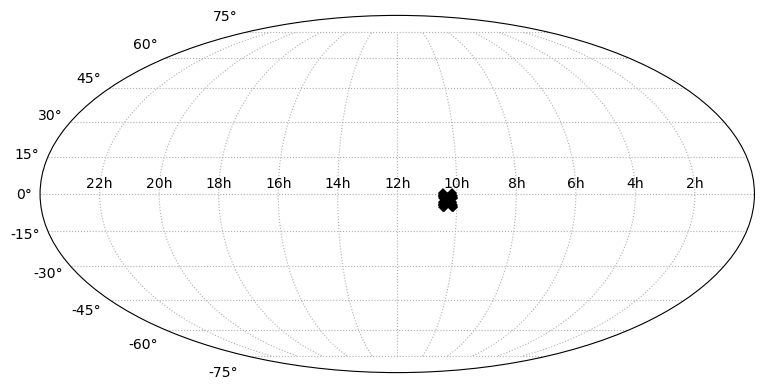

In [41]:
nest_ids = grp_ids 
idx = np.in1d(VI_tab['GroupID'], nest_ids) 
grp_lon = VI_tab['RA_LEDA'][idx]
grp_lat = VI_tab['DEC_LEDA'][idx]

group_coords = SkyCoord(grp_lon, grp_lat, unit='deg')

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})
for coord in group_coords:
    _ra = np.radians(180*u.deg - coord.transform_to('icrs').ra)
    _dec = np.radians(coord.transform_to('icrs').dec)
    ax.plot(_ra, _dec, 'kx', ms=10, mew=5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');

In [42]:
def geometric_median(X, eps=1e-6):
    """Compute the weighted geometric median of a set of points using Weiszfeld's algorithm.

    From https://github.com/scoutant/l1-median. Weiszfeld's algorithm may fail to converge
    if a guess is located on top of one of the initial points. If that occurs, move the guess.
    
    A summary of other algorithms is provided in
    https://www.cs.cmu.edu/~./glmiller/Publications/Papers/CLMPS16.pdf.

    Parameters
    ----------
    X : ndarray
        list of sample points (n-D), given as a 2D array
    eps : float
        Tolerance for convergence to the median.

    Returns
    -------
    y : ndarray
        First n-D estimate of the median satisfying the tolerance.
    """
    #- See with the geometric mean
    y = np.mean(X,0)
    while True:
        #- Compute Euclidean distances. Move away to avoid any null distances.
        while np.any(cdist(X,[y])==0):
            y +=0.1*np.ones(len(y))
            
        #- Weights that are the inverse of the distances from current estimate to the observations
        W = 1/cdist(X,[y]) # element-wise
        
        #- Update is the weighted average of the observations
        y1 = np.sum(W*X,0)/np.sum(W) # sum along axis 0
        if euclidean(y,y1) < eps:
            return y1
        y = y1

def group_median_coords(galaxy_coords):
    """Compute the geometric median coordinate of the galaxies in a group.

    Parameters
    ----------
    galaxy_coords : ndarray
        List of SkyCoords for galaxies in a cluster or group.

    Returns
    -------
    gal_median : SkyCoord
        Coordinates of the geometric median.
    """
    #- Pack the group's coordinates into an array of Cartesian coordinates
    galcoords = []
    for galaxy in galaxy_coords:
        galcoords.append(galaxy.represent_as('cartesian').get_xyz())
    galcoords = np.asarray(galcoords)

    #- Compute the geometric median.
    gm = geometric_median(galcoords)
    lonlat = SkyCoord(x=gm[0], y=gm[1], z=gm[2], representation_type='cartesian').transform_to('icrs').represent_as('unitspherical')
    gal_median = SkyCoord(ra=lonlat.lon.deg, dec=lonlat.lat.deg, unit='degree', frame='icrs')

    return gal_median

In [43]:
def plot_group_members(grpcat1, grpcat2, grpid, sgacat, sgaid):
    '''Generate a set of diagnostic plots for the members of a cluster.'''
    colors = plt.get_cmap('Dark2').colors
    #- Handling catalog length nonsense; grpcat1 or grpcat2 may be missing galaxies, so check which is longer
    
    grp_idx1 = np.in1d(grpcat1['GroupID'], grpid)
    grp_idx2 = np.in1d(grpcat2['GroupID'], grpid)
    grpcat1_len = len(grpcat1['RAdeg'][grp_idx1])
    grpcat2_len = len(grpcat2['RA_LEDA'][grp_idx2])
    
    # Choosing the catalog that has the larger galaxy count to run with
    if grpcat1_len > grpcat2_len: 
        grpcat = grpcat1
        grp_coord = SkyCoord(ra=grpcat['RAdeg'][grp_idx1], dec=grpcat['DEdeg'][grp_idx1], unit='deg', frame='icrs')
        z_grp = grpcat['zob'][grp_idx1]
    else: 
        grpcat = grpcat2
        grp_coord = SkyCoord(ra=grpcat['RA_LEDA'][grp_idx2], dec=grpcat['DEC_LEDA'][grp_idx2], unit='deg', frame='icrs')
        z_grp = grpcat['Z_DESI'][grp_idx2]

    #- Get group median coordinates for all galaxies in the group 
    grp_idx = np.in1d(grpcat['GroupID'], grpid)
    grp_coord_med = group_median_coords(grp_coord)
    
    z_grp_sorted = np.sort(z_grp)
    ngal_grp = len(z_grp_sorted)
    z_grp_med = np.mean(z_grp_sorted[ngal_grp//2:ngal_grp//2 + 2]) if (ngal_grp % 2 == 0) else z_grp_sorted[ngal_grp//2]
    
    #- Get SGA galaxy coordinates and median of observations
    sga_idx = np.in1d(sgacat['SGA_ID'], sgaid)
    sga_coord = SkyCoord(ra=sgacat['RA_LEDA'][sga_idx], dec=sgacat['DEC_LEDA'][sga_idx], unit='deg', frame='icrs')
    sga_coord_med = group_median_coords(sga_coord)
    
    z_sga = sgacat['Z_DESI'][sga_idx]
    z_sga_sorted = np.sort(z_sga)
    ngal_sga= len(z_sga_sorted)
    z_sga_med = np.mean(z_sga_sorted[ngal_sga//2:ngal_sga//2 + 2]) if (ngal_sga % 2 == 0) else z_sga_sorted[ngal_sga//2]

    #- Calculate R2t to plot
    grp_R2t = np.max(grp_coord.separation(grp_coord_med))/3

    dz = 0.001
    delta_angle = 0.25
    ramin = np.min(grp_coord.ra.deg)
    ramax = np.max(grp_coord.ra.deg)
    decmin = np.min(grp_coord.dec.deg)
    decmax = np.max(grp_coord.dec.deg)
    zmin = np.min(np.round(z_grp, 2)) - 4*dz
    zmax = np.max(np.round(z_grp, 2)) + 4*dz

    #- Plot the angular coordinates and redshifts
    fig = plt.figure(figsize=(12,8), tight_layout=True)
    ax = plt.subplot(231, projection='astro degrees zoom', center=grp_coord_med, radius=4*grp_R2t)

    outer = SphericalCircle(grp_coord_med, 3*grp_R2t, edgecolor=colors[7], linestyle='solid', transform=ax.get_transform('world'), facecolor='none')
    ax.add_patch(outer)

    inner = SphericalCircle(grp_coord_med, 1.5*grp_R2t, edgecolor=colors[7], linestyle='dotted', transform=ax.get_transform('world'), facecolor='none')
    ax.add_patch(inner)

    ax.grid()
    
    # transform=ax.get_transform('world'),
    ax.plot(grp_coord.ra.deg, grp_coord.dec.deg, 'k.', transform=ax.get_transform('world'), alpha = .25)
    ax.plot(grp_coord_med.ra.deg, grp_coord_med.dec.deg, 'kx', transform=ax.get_transform('world'), ms=7, mew=3)
    ax.plot(sga_coord.ra.deg, sga_coord.dec.deg, 'o',transform=ax.get_transform('world'),  label=f'{grpid}')
    ax.plot(sga_coord_med.ra.deg, sga_coord_med.dec.deg, 'D', color = colors[1], transform=ax.get_transform('world'), ms=5, mew=5)
        
    ax.set(xlabel=r'$\alpha$ [deg]', ylabel=r'$\delta$ [deg]')
    
    #- Plot the declination vs. redshift and velocity limits
    ax = plt.subplot(232)
    ax.plot(z_grp, grp_coord.dec.deg, 'k.', alpha = .25)
    ax.plot(z_sga, sga_coord.dec.deg, 'o', label=f'{grpid}')
    ax.plot(z_grp_med, grp_coord_med.dec.deg, 'kx', ms=7, mew=3)
    ax.plot(z_sga_med, sga_coord_med.dec.deg, 'D', color = colors[1], ms=5, mew=5)
    
    ax.set(xlabel='redshift',
           ylabel=r'$\delta$ [deg]',
           xlim=(zmin-dz, zmax+dz),
           ylim=(decmin-delta_angle, decmax+delta_angle))
    
    #- Plot the right ascension vs. redshift and velocity limits
    ax = plt.subplot(233)
    ax.plot(grp_coord.ra.deg, z_grp, 'k.', alpha = .25)
    ax.plot(sga_coord.ra.deg, z_sga, 'o', label=f'{grpid}')
    ax.plot(grp_coord_med.ra.deg, z_grp_med, 'kx', ms=7, mew=3)
    ax.plot(sga_coord_med.ra.deg, z_sga_med, 'D', color = colors[1], ms=5, mew=5)
    ax.set(xlabel=r'$\alpha$ [deg]',
           ylabel='redshift',
           xlim=(ramin-delta_angle, ramax+delta_angle),
           ylim=(zmin-dz, zmax+dz))
    
    #- Histograms of RA, Dec, and redshift:
    
    ax = plt.subplot(234)
    ax.hist(grp_coord.ra.deg, bins=np.arange(ramin-delta_angle, ramax+delta_angle, delta_angle), color = 'k', alpha = .25)
    ax.hist(sga_coord.ra.deg, bins=np.arange(ramin-delta_angle, ramax+delta_angle, delta_angle))
    ax.vlines(grp_coord_med.ra.deg, 0, 50, colors='k', linestyles='dotted')
    ax.vlines(sga_coord_med.ra.deg, 0, 50, colors = colors[1], linestyles='dotted')
    ax.set(xlabel=r'$\alpha$ [deg]',
           xlim=(ramin-delta_angle, ramax+delta_angle),
           ylabel='count',
           ylim=(0,45))

    ax = plt.subplot(235)
    ax.hist(grp_coord.dec.deg, bins=np.arange(decmin-delta_angle, decmax+delta_angle, delta_angle), color = 'k', alpha = .25)
    ax.hist(sga_coord.dec.deg, bins=np.arange(decmin-delta_angle, decmax+delta_angle, delta_angle))
    ax.vlines(grp_coord_med.dec.deg, 0, 50, colors='k', linestyles='dotted')
    ax.vlines(sga_coord_med.dec.deg, 0, 50, colors=colors[1], linestyles='dotted')

    ax.set(xlabel=r'$\delta$ [deg]',
           xlim=(decmin-delta_angle, decmax+delta_angle),
           ylabel='count',
           ylim=(0,45))

    ax = plt.subplot(236)
    ax.hist(z_grp, bins=np.arange(zmin, zmax + dz, dz), color = 'k', alpha = .25)
    ax.hist(z_sga, bins=np.arange(zmin, zmax + dz, dz))
    ax.vlines(z_grp_med, 0, 50, colors='k', linestyles='dotted')
    ax.vlines(z_sga_med, 0, 50, colors = colors[1], linestyles='dotted')
    ax.set(xlabel='redshift',
           xlim=(zmin-dz, zmax+dz),
           ylabel='count',
           ylim=(0,45))
    fig.suptitle(f'TF Jura Observations of Tempel et al. Group {grpid}')

    return fig, sga_coord_med, grp_coord_med, z_sga, z_grp, z_sga_med, z_grp_med

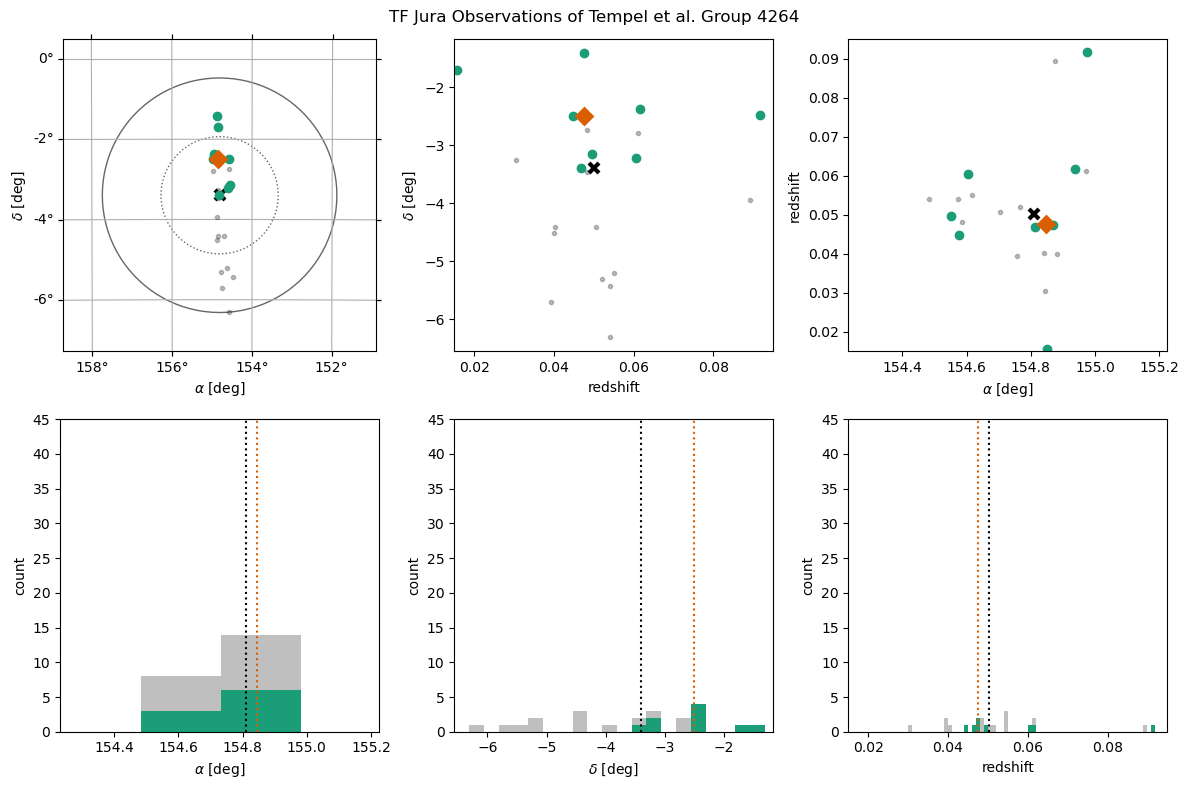

In [44]:
sga_coords_med = []
grp_coords_med = []
zs_sga_med = []
zs_grp_med = []
zs_sga = []
zs_grp = []

for groupid in sga_groups.keys():
    fig, sga_coord_med, grp_coord_med, z_sga, z_grp, z_sga_med, z_grp_med = plot_group_members(groups, sgatab_sel, groupid, VI_tab, sga_groups[groupid])
    grp_coords_med.append(grp_coord_med)
    sga_coords_med.append(sga_coord_med)
    zs_sga_med.append(z_sga_med)
    zs_grp_med.append(z_grp_med)
    zs_sga.append(z_sga)
    zs_grp.append(z_grp)

In [45]:
for i, (group_id, sga_ids) in enumerate(sga_groups.items()):
    print(f'{i+1:2d} {group_id:7d} {len(sga_ids):3d} galaxies')

 1    4264   9 galaxies


# Apply Cluster Selection

We don't have information like $\angle(R_{2t})$, $v_\text{cluster}$, or $\sigma_P$ for this catalog, so the cluster selection is based off of RA, DEC, and $z$ as plotted above. We calculate the difference between the geometric median cluster center after cuts and the geometric median cluster center before cuts $(RA_\text{med}, DEC_\text{med})$, as well as the difference in median redshifts $z_\text{med}$. 

* $\Delta\theta$: the angular separation between the median position of the selected observations and the total observations.
* $\angle(R_{2t})$: the angular projection of the cluster second turnaround radius. Since this isn't a value in the Tempel catalog, we approximate it using the distance from the median of the total observations to the furthest away point.
* $\Delta v = v_\text{cluster} - v_\text{SGA,median}$.
* $\sigma_P$: the velocity dispersion of the cluster.

A reasonable selection appears to be
1. $\Delta\theta / \angle(R_{2t}) < 1$
2. $\Delta v/ \sigma_P < 1$ (when I figure out how to get $\sigma_P$)

In [46]:
group_ids = np.asarray(grp_ids)

med_separation = []
max_separation = []
norm_separation = []

for median in range(len(sga_coords_med)): 
    separation = sga_coords_med[median].separation(grp_coords_med[median]).to('rad')
    med_separation.append(separation)

for i in range(len(grp_coords_med)): 
    med = grp_coords_med[i]
    idx = np.in1d(sgatab_sel['GroupID'], group_ids[i])
    gal = SkyCoord(ra=sgatab_sel['RA_LEDA'][idx], dec=sgatab_sel['DEC_LEDA'][idx], unit='deg', frame='icrs')
    max_separation.append(np.max(gal.separation(med).to('rad')))

for n in range(len(med_separation)): 
    norm_separation.append(med_separation[n]/max_separation[n])

sep_cut_ids = []
sep_cut_ids_rej = []
for i in range(len(norm_separation)): 
    if norm_separation[i] < 1/3: 
        sep_cut_ids.append(group_ids[i])
    else: 
        sep_cut_ids_rej.append(group_ids[i])

sep_keep_group = sep_cut_ids
sep_reject_group = sep_cut_ids_rej
print('keep:', sep_keep_group)
print('drop:', sep_reject_group)

keep: [4264]
drop: []


In [47]:
group_ids = np.asarray(grp_ids) 
cz_grp_med = []
cz_sga_med = []
norm_v = []
delta_v = []
sigma_p = []
cz_grp = []
delv_sigp = []

# find ∆v 
for z in range(len(zs_grp_med)): 
    v = c_kms*zs_grp_med[z]
    cz_grp_med.append(v)
    
for z in range(len(zs_sga_med)): 
    v = c_kms*zs_sga_med[z]
    cz_sga_med.append(v)

for cz in range(len(cz_grp_med)): 
    dv = cz_grp_med[cz] - cz_sga_med[cz]
    delta_v.append(dv)

# find sigP
for z in range(len(zs_grp)): 
    v = c_kms*zs_grp[z]
    cz_grp.append(v)

for cz in range(len(cz_grp)): 
    sp = np.std(cz_grp[cz])
    sigma_p.append(sp)

for i in range(len(delta_v)): 
    ratio = delta_v[i]/sigma_p[i]
    delv_sigp.append(ratio)

v_cut_ids = []
v_cut_ids_rej = []

for i in range(len(delv_sigp)): 
    if np.abs(delv_sigp[i]) < 1: 
        v_cut_ids.append(group_ids[i])
    else: 
        v_cut_ids_rej.append(group_ids[i])

v_keep_group = v_cut_ids
v_reject_group = v_cut_ids_rej
print('keep:', v_keep_group)
print('drop:', v_reject_group)

keep: [4264]
drop: []


In [48]:
grp_ids = []
keep_group = []
reject_group = []
for i in group_ids: 
    if i in sep_keep_group and v_keep_group: 
        grp_ids.append(i)
        keep_group.append(i)
    else: 
        reject_group.append(i)
print(grp_ids)

[4264]


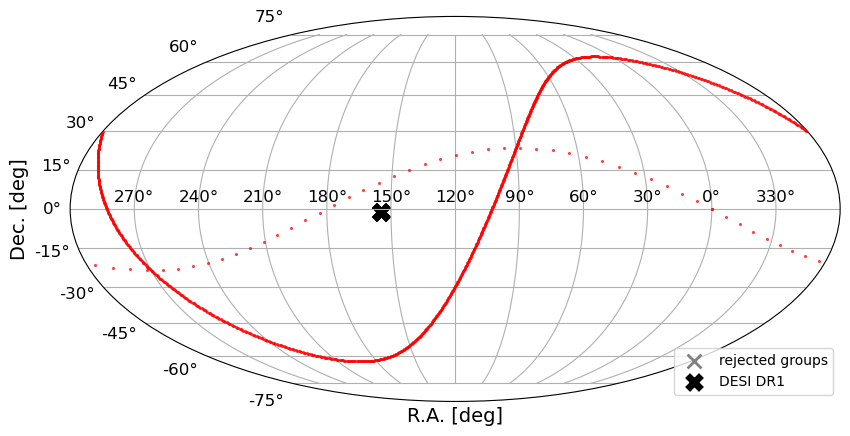

In [49]:
select = grp_ids
grp_ids = np.asarray(list(sga_groups.keys()))
good_idx = np.in1d(groups['GroupID'], keep_group)
bad_idx = np.in1d(groups['GroupID'], reject_group)
good_group_coords = SkyCoord(groups['RAdeg'][good_idx], groups['DEdeg'][good_idx], unit='deg')
bad_group_coords = SkyCoord(groups['RAdeg'][bad_idx], groups['DEdeg'][bad_idx], unit='deg')

ax = init_sky()

ax.scatter(ax.projection_ra(bad_group_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(bad_group_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=2,
           color='gray', 
           label='rejected groups')

ax.scatter(ax.projection_ra(good_group_coords.transform_to('icrs').ra.value), 
           ax.projection_dec(good_group_coords.transform_to('icrs').dec.value), 
           marker='x', 
           s=100,
           linewidth=5,
           color='black', 
           label='DESI DR1')

ax.xaxis.label.set_size(14)
ax.yaxis.label.set_size(14)

plt.legend(loc='lower right')

plt.tick_params(axis='both', which='major', labelsize=12);

## Plot Galaxy groups that Failed the Selection

In [50]:
for group_id in sga_groups.keys():
    if group_id in reject_group:
        fig = plot_group_members(groups, group_id, VI_tab, sga_groups[group_id], False, group_id, group_id)
        # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_reject.png', dpi=150);

## Plot Galaxy groups that Passed the Selection

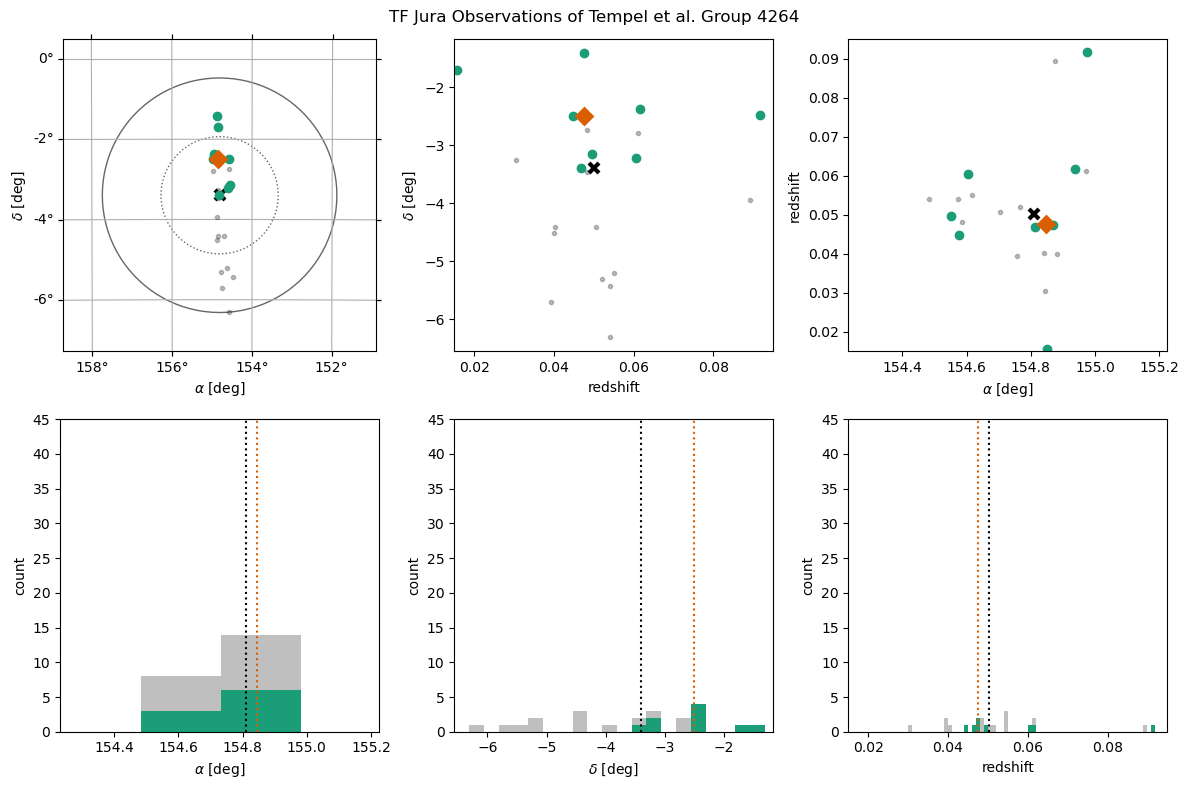

In [51]:
for cluster_id in sga_groups.keys():
    fig = plot_group_members(groups, sgatab_sel, group_id, VI_tab, sga_groups[group_id])
        # fig.savefig(f'../../Figures/Y1/TF_Y1_cluster_{cluster_id}_accept.png', dpi=150);

# Build the Calibration Table of SGA Galaxies in groups

In [52]:
caltab = None    # Table of selected clusters and SGA galaxies
rejtab = None    # Table of clusters failing the selection

for group_id, sga_ids in sga_groups.items():
    if group_id in keep_group:
        idx = np.in1d(VI_tab['SGA_ID'], sga_ids)
        grouptab = VI_tab[idx]
        grouptab['GROUP_ID'] = group_id
        caltab = grouptab if caltab is None else vstack([caltab, grouptab])
    
    else:
        idx = np.in1d(VI_tab['SGA_ID'], sga_ids)
        grouptab = VI_tab[idx]
        grouptab['GROUP_ID'] = group_id
        
        rejtab = grouptab if rejtab is None else vstack([rejtab, grouptab])
    
# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1.fits', overwrite=True)
if caltab is not None: 
    print(len(caltab))
elif caltab is None: 
    print('no groups')
    
caltab[['GROUP_ID', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_err']][:5]

9


GROUP_ID,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_err
int64,float64,float64,float64,float64,float64
4264,147166.0,15.598097438085823,0.12190168299417824,146.14325428123772,8.830389887985746
4264,236390.0,16.253376073539258,0.11097879327843886,132.93922779098187,2.08771948643144
4264,343457.0,15.09672172171995,0.13719735009576528,162.6153754092303,20.780725749437533
4264,535957.0,15.289592673573644,0.05553365677921825,233.89969651745776,3.9072595110719353
4264,579975.0,14.978918220000342,0.0686689113548696,164.0305393055502,3.4466387371988434


In [53]:
# Save SGA IDs for each group that is part of the calibration (for Alex's Bayesian calibration)
for group in np.unique(caltab['GROUP_ID']):
    output_filename = 'output_' + str(group) + '.txt'
    # SGA_IDs_in_cluster = Table()
    # SGA_IDs_in_cluster['SGA_ID'] = c_4r_in_cluster[i]
    caltab[['SGA_ID']][caltab['GROUP_ID'] == group].write(output_filename, 
                                                              format='ascii.commented_header', 
                                                              overwrite=True)

In [54]:
if rejtab is None: 
    print('no rejects')
else:
    print(len(rejtab))
    rejtab[:5]

no rejects


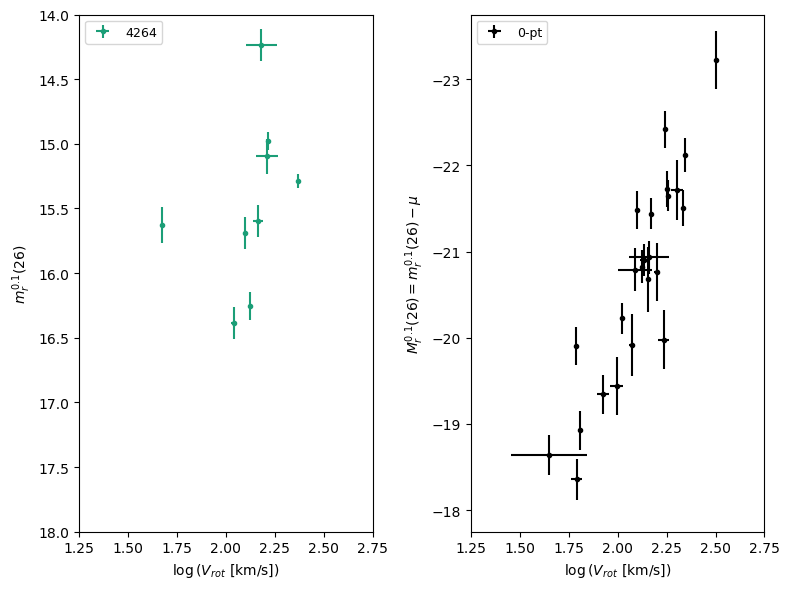

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)

logV0 = 0

ax = axes[0] 

if rejtab is not None:
    #- Plot galaxies with failed group selections.
    _group_ids = np.unique(rejtab['GROUP_ID'])
    markers = 'sDv^<>'
    for j, _group_id in enumerate(_group_ids):
        select_group = np.in1d(rejtab['GROUP_ID'], _group_id)
    
        #- Store independent variable for each group
        logv = np.log10(rejtab['V_0p4R26'][select_group].data) - logV0
        logv_err = 0.434*rejtab['V_0p4R26_err'][select_group].data / rejtab['V_0p4R26'][select_group].data
    
        #- Store dependent variable for each group
        mr26 = rejtab['R_MAG_SB26_CORR'][select_group].data
        mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_group].data
        
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 6], markersize=6, color='gray', alpha=0.3, label=f'{_group_id} (rej.)')

#- Plot galaxies and groups passing all selections.
_group_ids = np.unique(caltab['GROUP_ID'])

for _group_id in _group_ids:
    select_group = np.in1d(caltab['GROUP_ID'], _group_id)

    #- Store independent variable for each group
    logv = np.log10(caltab['V_0p4R26'][select_group].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_err'][select_group].data / caltab['V_0p4R26'][select_group].data

    #- Store dependent variable for each group
    mr26 = caltab['R_MAG_SB26_CORR'][select_group].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_group].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', label=f'{_group_id}')

ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[18, 14],
       ylabel=r'$m_r^{0.1} (26)$')
ax.legend(loc='upper left', fontsize=9)

#- Plot the 0-pt calibrators
ax = axes[1]

logv = np.log10(zeroptab['V_0p4R26'].data) - logV0
logv_err = 0.434*zeroptab['V_0p4R26_err'].data / zeroptab['V_0p4R26'].data
mr26 = zeroptab['R_ABSMAG_SB26'].data
mr26_err = zeroptab['R_ABSMAG_SB26_err'].data

ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='k.', label='0-pt')
ax.set(xlim=[1.25, 2.75],
       xlabel=r'$\log{(V_{rot}~[\mathrm{km/s}]}$)',
       ylim=[-17.75, -23.75],
       ylabel=r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$')
ax.legend(loc='upper left', fontsize=9);

# fig.savefig('../../Figures/Y1/TF_Y1_group_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [56]:
#- Extract successful groups
_group_ids = np.unique(caltab['GROUP_ID'])
m = len(_group_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []

# logV0 = 2.25
logV0 = np.median(np.concatenate([np.log10(caltab['V_0p4R26']), 
                                  np.log10(zeroptab['V_0p4R26'])]))
print('logV0 =', logV0)

# Start with the zero-point calibrators
logV.append(np.log10(zeroptab['V_0p4R26']) - logV0)
logV_err.append(0.434*zeroptab['V_0p4R26_err'] / zeroptab['V_0p4R26'])
mag.append(zeroptab['R_ABSMAG_SB26'])
mag_err.append(zeroptab['R_ABSMAG_SB26_err'])

#- Loop over the SGA groups
for k, _group_id in enumerate(_group_ids):
    select_group = np.in1d(caltab['GROUP_ID'], _group_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_group]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_err'][select_group] / caltab['V_0p4R26'][select_group])
    mag.append(caltab['R_MAG_SB26_CORR'][select_group])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_group])

logV0 = 2.1555003112454787


## Multiline Fit using HyperFit

In [57]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += [(-40,0)] + m*[(-20, 20)]    # Bounds on b (intercepts: 0-pt + groups)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

     fun: -1157.8431998053263
     jac: array([-0.01584795, -0.01161879,  0.00597993, -0.00618456])
 message: 'Optimization terminated successfully.'
    nfev: 3045
     nit: 49
 success: True
       x: array([ -7.11788646, -21.00273006,  15.24474353,   0.68256211])
Ndim: 4 2


100%|██████████| 1000/1000 [00:01<00:00, 509.40it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.95135952 35.98840789 35.70558131 38.19906888] / 2047.5679760923526


100%|██████████| 1000/1000 [00:01<00:00, 529.85it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.74037061 53.36015239 41.21376961 47.19328894] / 2668.0076197372923


100%|██████████| 1000/1000 [00:01<00:00, 532.40it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [39.15019578 44.79710302 39.83955313 42.96068445] / 2239.85515079981


100%|██████████| 1000/1000 [00:01<00:00, 534.98it/s]

Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [40.76755298 44.33138578 39.91224284 42.98852154] / 2216.569289147121


In [58]:
temp_outfile = open('cov_ab_iron_jointTFR_tempely1.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0), temp_outfile)
temp_outfile.close()

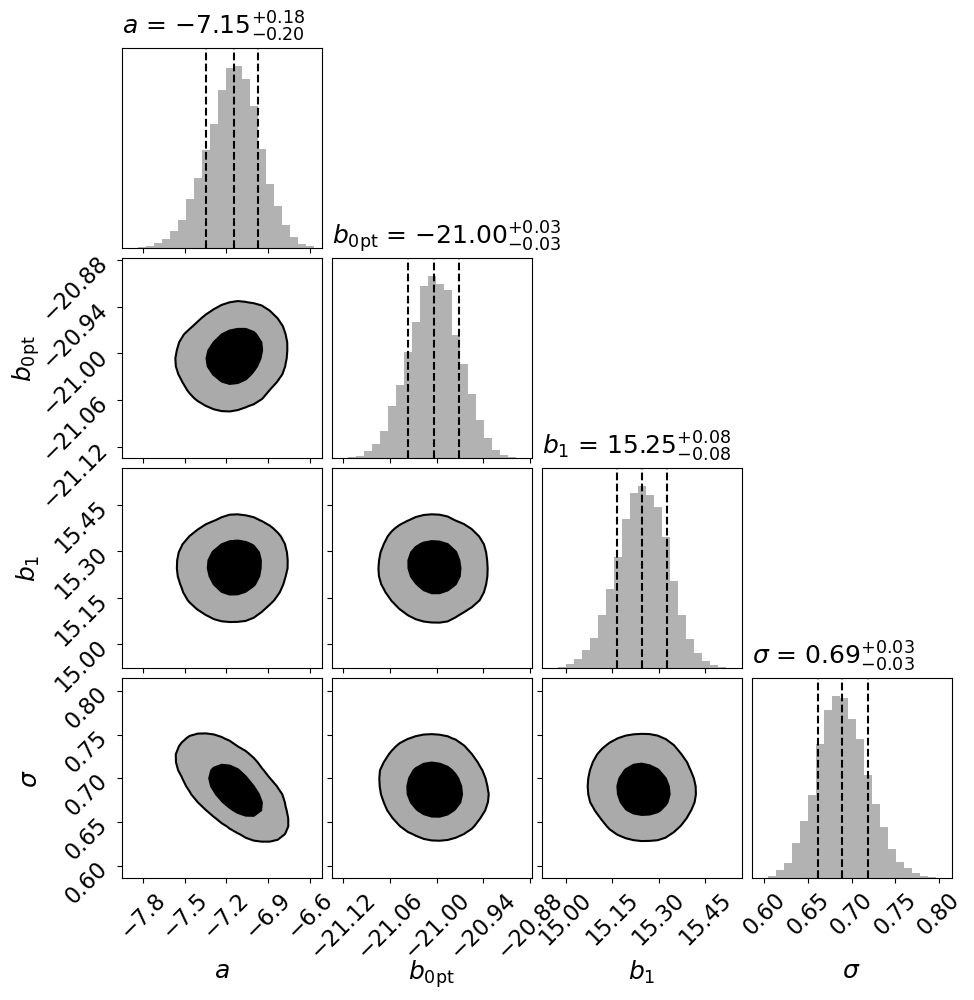

In [59]:
labels  = ['$a$']
labels += ['$b_{0\mathrm{pt}}$'] + [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$'] #+ [rf'$\sigma_{k}$' for k in np.arange(m)]

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
#              range=[[1.9, 2.4], [0.75, 1.1], [0.1, 0.3]],   # Range for a, b, sigma. Adjust as needed.
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_group_calibration_binaryMLupdated_z0p1_corner0_20241220.png', dpi=150, facecolor='none');

### Plot the HyperFit Results

In [60]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+2):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

-7.148031329099057


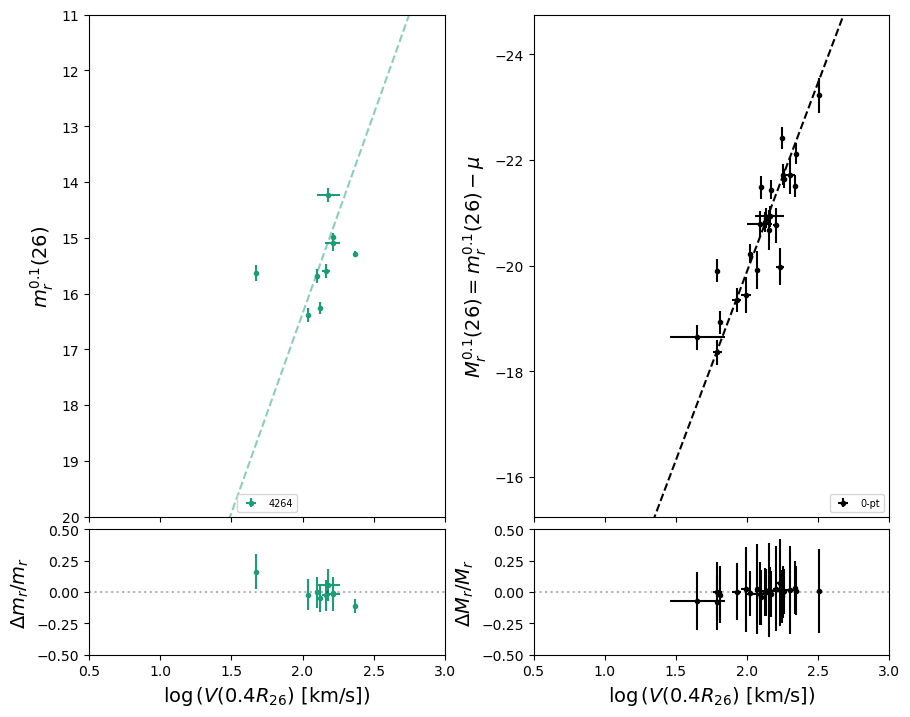

In [61]:
fig, axes = plt.subplots(2,2, figsize=(10,8), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot groups
ax = axes[0,0]

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_group_ids[k]}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)#, label='fit')

ax.set(xlim=[.5, 3],
       ylim=[20, 11]
      )
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
ax.legend(loc='lower center', fontsize=7, ncol = 3);

#- Plot calibrators
ax = axes[0,1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='k.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[.5, 3],
       ylim=[-15.25, -24.75]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='lower right', fontsize=7)

#- Plot residuals: clusters
ax = axes[1,0]

for k in range(m):
    logv_obs = logV[k+1]
    m_obs = mag[k+1]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_group_ids[k]}')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[.5, 3],
       ylim=[-0.5, 0.5])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

#- Plot residuals: calibrators
ax = axes[1,1]

logv_obs = logV[0]
m_obs = mag[0]
m_exp = (a_*logv_obs + b0pt)

b = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, xerr=logV_err[0], yerr=mag_err[0],
                     fmt='k.', label=f'0-pt')
ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(xlim=[.5, 3],
       ylim=[-0.5, 0.5])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta M_r/M_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('../../Figures/Y3/TF_Y3_cluster_calibration.png', dpi=150, facecolor='none')
print(a_)

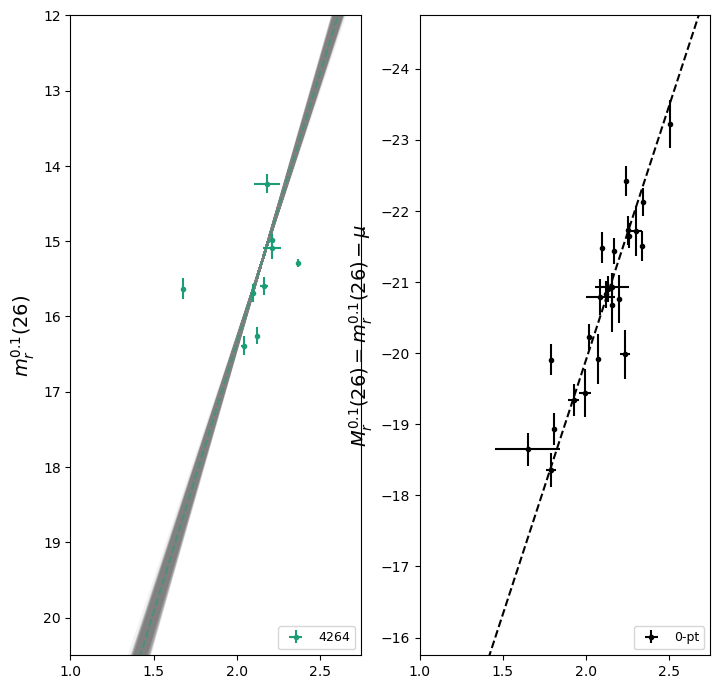

In [62]:
fig, axes = plt.subplots(1,2, figsize=(8, 8), sharex=True)#,gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b0pt = b_mcmc[0,1]
b_   = b_mcmc[:,1][1:]

#- Plot groups
ax = axes[0]

_logv = np.arange(0, 3, 0.1) - logV0

for (_a, _b0, _b1, _s) in tfr_mcmc_samples[:, ::100].T:
    ax.plot((_logv + logV0), _a*_logv + np.mean(b_), color='gray', alpha=0.1)
    
for k in range(m):
    eb = ax.errorbar(x=logV[k+1] + logV0, y=mag[k+1], xerr=logV_err[k+1], yerr=mag_err[k+1],
                     fmt='.', label=f'{_group_ids[k]}')
    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)#, label='fit')

ax.set(xlim=[1, 2.75],
       ylim=[20.5, 12]
      )
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
ax.legend(loc='lower right', fontsize=9, ncol=2);


#- Plot calibrators
ax = axes[1]
eb = ax.errorbar(x=logV[0] + logV0, y=mag[0], xerr=logV_err[0], yerr=mag_err[0],
                 fmt='k.', label=f'0-pt')

ax.plot(_logv + logV0, a_*_logv + b0pt, color=eb[0].get_color(), ls='--')#, label='fit')
ax.set(xlim=[1, 2.75],
       ylim=[-15.75, -24.75]
      )
ax.set_ylabel(r'$M_r^{0.1}(26) = m_r^{0.1}(26) - \mu$', fontsize=14)
ax.legend(loc='lower right', fontsize=9, ncol=2)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);
# fig.savefig('../../Figures/Y1/TF_Y1_group_calibration_0pt_binaryMLupdated_z0p1_fit0_20241220.png', dpi=150, facecolor='none')

### Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

#### Define the line perpendicular to the calibration

In [63]:
logV_n17 = (-17 - b0pt)/a_ + logV0
# b_perp = -17 + (logV_n17 - logV0)/a_
# b_perp

mr_n17 = a_*(logV_n17 - logV0) + b_
b_perp = mr_n17 + (logV_n17 - logV0)/a_

print(10**logV_n17, 'km/s')

39.3952690525509 km/s


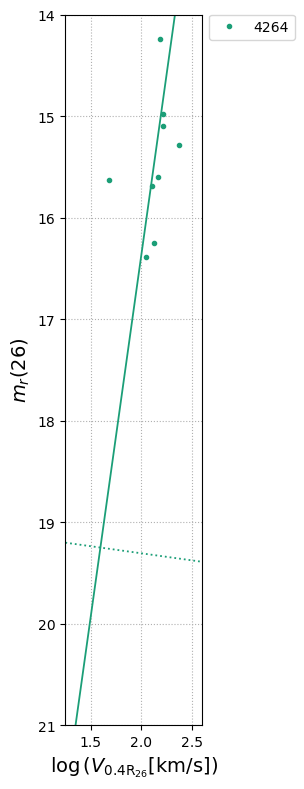

In [64]:
plt.figure(figsize=(4,8), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

for k in range(m):
    eb = plt.plot(logV[k+1] + logV0, mag[k+1], '.', label=f'{_group_ids[k]}')
    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), marker='None', ls='-', lw=1.3)
    plt.plot(_logv + logV0, -_logv/a_ + b_perp[k], color=eb[0].get_color(), marker='None', ls=':', lw=1.3)
    # plt.hlines(m_dwarf_groups[_group_ids[k]], 1.25, 2.75, colors=eb[0].get_color(), linestyles='dashed')
    
plt.xlabel(r'$\log{(V_\mathrm{0.4R_{26}} [\mathrm{km/s}])}$', fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0)

plt.xlim(1.25, 2.6)
plt.ylim(21, 14)

plt.gca().set_aspect('equal');

#### Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.4R_{26})) - V_0)/a + b_{\rm group \perp}
\end{equation}

In [65]:
dwarfs = np.zeros(len(caltab), dtype=bool)

for i in range(m):
    # Retrieve this group's nest ID
    nestid = _group_ids[i]
    
    # Find all galaxies in this group
    group_gal_idx = caltab['GROUP_ID'] == nestid
    
    # Find which of these group galaxies are dwarfs
    group_dwarfs = (caltab['R_MAG_SB26_CORR'][group_gal_idx] - caltab['R_MAG_SB26_ERR_CORR'][group_gal_idx]) > (-(np.log10(caltab['V_0p4R26'][group_gal_idx]) - logV0)/a_ + b_perp[k])
    
    # Set the boolean correctly
    dwarfs[group_gal_idx] = group_dwarfs
    
caltab_bright = caltab[~dwarfs]

print(np.sum(dwarfs))

0
